# Chapter-7 Knowledge Distillation for Edge AI.ipynb

#### In this notebook, we will try to train a ResNet10 student model from pretrained ResNet18 model in Pytorch. We will first train the ResNet18 model on Cats v/s Dogs dataset and then use knowledge distillation technique to train ResNet10 model.

### Step-1: Setup infra for training model on Cats v/s Dogs dataset

We will be using Cats v/s Dogs dataset from huggingface.
Link: https://huggingface.co/datasets/microsoft/cats_vs_dogs

<div style="text-align: center;">
    <h3>Architecture of ResNet18 and ResNet10 model</h3>
</div>

<table>
  <tr>
    <td style="padding-right: 30px;">
        <img src="ResNet18.png" width="200"><br><center><b>ResNet18</b></center>
    </td>
    <td style="left: 30px;">
        <img src="ResNet10.png" width="200"><br><center><b>ResNet10</b></center>
    </td>
  </tr>
</table>


In [26]:
# Install dependencies
!pip install onnx==1.18.0 onnxruntime==1.22.0 netron==8.4.3
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 \
    --index-url https://download.pytorch.org/whl/cu124 --force-reinstall
!pip install datasets==4.0.0 torchinfo==1.8.0 matplotlib==3.10.3

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cuda_nvrt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
ERROR: Operation cancelled by user
^C


In [1]:
import os
import copy
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from datasets import load_dataset
from torchvision import transforms
from collections import defaultdict
from torch.utils.data import DataLoader, random_split

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(42)

In [2]:
# Setup Dataset object for training

class CatDogDataset(torch.utils.data.Dataset):
    # Load dataset from Hugging Face
    dataset = load_dataset("microsoft/cats_vs_dogs")

    # Split dataset into train and test sets
    train_size = int(0.8 * len(dataset["train"]))
    test_size = len(dataset["train"]) - train_size
    train_dataset, test_dataset = random_split(
        dataset["train"], [train_size, test_size]
    )

    def __init__(self, is_train=True):
        if is_train:
            self.ds = self.__class__.train_dataset
            self.transform_fn = self.transforms()
        else:
            self.ds = self.__class__.test_dataset
            self.transform_fn = self.transforms()

    def transforms(self):
        transform = transforms.Compose(
            [
                T.Resize((224, 224)),
                T.Lambda(
                    lambda img: img.convert("RGB") if img.mode != "RGB" else img
                ),  # Convert grayscale to RGB
                T.ToTensor(),
                T.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # ImageNet normalization
            ]
        )
        return transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        example = self.ds[idx]
        img = example["image"]
        example.pop("image")
        example["images"] = self.transform_fn(img)
        example["labels"] = torch.tensor(example["labels"], dtype=torch.long)
        return example

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# Setup the training class

class Trainer:
    def __init__(
        self,
        model,
        train_dataset,
        test_dataset,
        batch_size,
        num_workers,
        num_epochs,
        lr,
        device,
        model_name,
    ):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_epochs = num_epochs
        self.lr = lr
        self.device = device
        self.model_name = model_name

        self.train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
        )
        self.test_loader = DataLoader(
            test_dataset, batch_size=batch_size, num_workers=num_workers
        )
        self.model = model
        print(summary(model, input_size=(1, 3, 224, 224)))
        self.model = self.model.to(self.device)

    def fit(self):
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        # Training loop
        train_acc_list = []
        test_acc_list = []
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0
            for batch in tqdm(self.train_loader):
                images, labels = (
                    batch["images"].to(self.device),
                    batch["labels"].to(self.device),
                )
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

            train_acc = (correct / total) * 100
            train_acc_list.append(train_acc)
            print(
                f"Epoch {epoch + 1}/{self.num_epochs}, "
                f"Loss: {total_loss / len(self.train_loader)}, "
                f"Accuracy: {train_acc:.2f}%"
            )

            # Test loop
            test_acc = self.test()
            test_acc_list.append(test_acc)
            print(f"Test Accuracy: {test_acc:.2f}%")

        # Save Model
        torch.save(
            self.model.state_dict(),
            f"{self.model_name.replace('.', '_').replace('/', '_')}.pth",
        )
        return train_acc_list, test_acc_list

    def test(self):
        # Test loop
        self.model.to(self.device)
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in tqdm(self.test_loader):
                images, labels = (
                    batch["images"].to(self.device),
                    batch["labels"].to(self.device),
                )
                outputs = self.model(images)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
        acc = correct / total * 100
        return acc

In [4]:
# Setup dataset

train_dataset = CatDogDataset(is_train=True)
test_dataset = CatDogDataset(is_train=False)

In [5]:
# Define Hyperparameters

NUM_CLASSES = 2
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 10
NUM_WORKERS = 4  # Adjust based on CPU cores
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step-2: Train ResNet18 using supervised learning

In [6]:
# Setup ResNet18 classifier model
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=2, ckpt_path=None):
        super(ResNet18Classifier, self).__init__()

        # Load pretrained resnet18
        self.model = models.resnet18(pretrained=True)

        # Update the last FC layer for 2 class classification problem
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Load the checkpoint if it is provided.
        if ckpt_path is not None:
            if not os.path.isfile(ckpt_path):
                raise FileNotFoundError(f"File not present at: {ckpt_path}.")
            self.model.load_state_dict(torch.load(ckpt_path))

    def forward(self, images):
        logits = self.model(images)
        return logits

In [7]:
# Train ResNet18 model on Cats v/s Dogs dataset. This model will be considered as teacher model.

MODEL_NAME = "resnet18_cats_dogs_normal"
base_model = ResNet18Classifier(num_classes=NUM_CLASSES, ckpt_path=None).to(DEVICE)

base_trainer = Trainer(
    base_model, train_dataset, test_dataset, BATCH_SIZE, NUM_WORKERS,
    EPOCHS, LR, DEVICE, MODEL_NAME
)
train_acc_list_r18, test_acc_list_r18 = base_trainer.fit()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

Layer (type:depth-idx)                        Output Shape              Param #
ResNet18Classifier                            [1, 2]                    --
├─ResNet: 1-1                                 [1, 2]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]          295,42

  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.17207961769793628, Accuracy: 93.13%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    if w.is_alive():

            ^ ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3

Test Accuracy: 94.90%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^

Epoch 2/10, Loss: 0.114936438336676, Accuracy: 95.43%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Test Accuracy: 94.66%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Exception ignored in:     Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__


    <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
self._shutdown_workers() Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Epoch 3/10, Loss: 0.1084376749894089, Accuracy: 95.84%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 95.04%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.07353080148995797, Accuracy: 97.05%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 97.03%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/10, Loss: 0.06753529449852315, Accuracy: 97.32%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 95.77%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():
    ^ ^ ^

Epoch 6/10, Loss: 0.05419600991228851, Accuracy: 97.89%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^
  File "/us

Test Accuracy: 96.41%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in:  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

Epoch 7/10, Loss: 0.050969398794896384, Accuracy: 98.00%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Exception ignored in: 

Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

        Traceback (most recent call last):
self._shutdown_workers()self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__


      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    

Test Accuracy: 94.66%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__


  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/u

Epoch 8/10, Loss: 0.05130377648040293, Accuracy: 98.15%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 96.77%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.03755338127338828, Accuracy: 98.77%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 94.62%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060

Epoch 10/10, Loss: 0.05038339920754587, Accuracy: 98.21%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 96.50%


In [8]:
print(f"ResNet18 Final Train Accuracy: {train_acc_list_r18[-1]:.2f}%")
print(f"ResNet18 Final Test Accuracy: {test_acc_list_r18[-1]:.2f}%")

ResNet18 Final Train Accuracy: 98.21%
ResNet18 Final Test Accuracy: 96.50%


### Step-3: Train ResNet10 using supervised learning

In [9]:
# Setup ResNet10 classifier model
from torchvision.models.resnet import _resnet, BasicBlock

class ResNet10Classifier(nn.Module):
    def __init__(self, num_classes=2, ckpt_path=None):
        super(ResNet10Classifier, self).__init__()

        # Define resnet10 based on torchvision definition
        self.model = _resnet(BasicBlock, [1, 1, 1, 1], None, False)

        # Update the last FC layer for 2 class classification problem
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Load the checkpoint if it is provided.
        if ckpt_path is not None:
            if not os.path.isfile(ckpt_path):
                raise FileNotFoundError(f"File not present at: {ckpt_path}.")
            self.model.load_state_dict(torch.load(ckpt_path))

    def forward(self, images):
        logits = self.model(images)
        return logits

In [10]:
# Train ResNet10 model on Cats v/s Dogs dataset on plain cross entropy loss. 
# That means based on only labeled data.
base_model = ResNet10Classifier(num_classes=NUM_CLASSES).to(DEVICE)

MODEL_NAME = "resnet10_cats_dogs_normal"
base_trainer = Trainer(
    base_model, train_dataset, test_dataset, BATCH_SIZE, NUM_WORKERS,
    EPOCHS, LR, DEVICE, MODEL_NAME
)
train_acc_list_r10, test_acc_list_r10 = base_trainer.fit()

Layer (type:depth-idx)                        Output Shape              Param #
ResNet10Classifier                            [1, 2]                    --
├─ResNet: 1-1                                 [1, 2]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-2                   [1, 128, 28, 28]          230,144
│    └─Sequential: 2-7                        [1, 256, 14, 14]          --
│    │    └─BasicBlock: 3-3                   [1, 256, 14, 14]          919,040
│ 

  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>^

^<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Traceback (most recent call last):
^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^Traceback (most recent call last):
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    

Epoch 1/10, Loss: 0.6180740572486721, Accuracy: 66.01%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/pyth

Test Accuracy: 71.49%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.48664143696783346, Accuracy: 76.48%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 79.67%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.4023025097649659, Accuracy: 81.55%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 80.12%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/10, Loss: 0.32579100977489567, Accuracy: 85.70%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 77.62%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/10, Loss: 0.26327942620721284, Accuracy: 88.82%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Test Accuracy: 89.00%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 6/10, Loss: 0.2081241429093653, Accuracy: 91.32%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
Exception ignored in: 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()

Test Accuracy: 89.04%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()        self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

self._shutdown_w

Epoch 7/10, Loss: 0.1655864715560279, Accuracy: 93.26%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 90.28%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.1265898892813308, Accuracy: 94.81%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 86.44%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 9/10, Loss: 0.10125957292650824, Accuracy: 96.02%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 89.32%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10/10, Loss: 0.07453413935038086, Accuracy: 97.13%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Test Accuracy: 90.56%


In [11]:
print(f"ResNet10 Final Train Accuracy: {train_acc_list_r10[-1]:.2f}%")
print(f"ResNet10 Final Test Accuracy: {test_acc_list_r10[-1]:.2f}%")

ResNet10 Final Train Accuracy: 97.13%
ResNet10 Final Test Accuracy: 90.56%


### Step-4: Train ResNet10 using supervised learning and knowledge distillation. We will use ResNet18 as teacher and ResNet10 as student model.

In [12]:
# Define the KDTrainer class which can help perform knowledge distillation training.

class KDTrainer:
    def __init__(self, teacher_model, student_model, train_dataset, test_dataset, batch_size, num_workers,
                num_epochs, lr, device, student_model_name):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_epochs = num_epochs
        self.lr = lr
        self.device = device
        self.student_model_name = student_model_name

        self.train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
        )
        self.test_loader = DataLoader(
            test_dataset, batch_size=batch_size, num_workers=num_workers
        )
        self.teacher_model = teacher_model
        self.student_model = student_model
        print("Teacher model summary:")
        print(summary(self.teacher_model, input_size=(1, 3, 224, 224)))
        print("Student model summary:")
        print(summary(self.student_model, input_size=(1, 3, 224, 224)))

        self.teacher_model = self.teacher_model.to(self.device)
        self.student_model = self.student_model.to(self.device)

    def distillation_loss(self, student_logits, teacher_logits, labels, T, alpha):
        # KL Div loss between student's logits and teacher's logits.
        soft_loss = nn.KLDivLoss(reduction='batchmean')(
                        F.log_softmax(student_logits/T, dim=1),
                        F.softmax(teacher_logits/T, dim=1)) * (T * T)

        # Cross entropy loss between student's prediction and ground truth labels.
        hard_loss = F.cross_entropy(student_logits, labels)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    def fit(self, T=5.0, alpha=0.5):
        # Optimizer
        optimizer = optim.Adam(self.student_model.parameters(), lr=self.lr)

        # Keep the teacher model frozen
        self.teacher_model.eval()

        # Training loop
        train_acc_list = []
        test_acc_list = []
        for epoch in range(self.num_epochs):
            self.student_model.train()
            total_loss = 0
            correct = 0
            total = 0
            for batch in tqdm(self.train_loader):
                images, labels = batch["images"].to(self.device), batch["labels"].to(self.device)
                optimizer.zero_grad()

                student_logits = self.student_model(images)
                with torch.no_grad():
                    teacher_logits = self.teacher_model(images)

                loss = self.distillation_loss(student_logits, teacher_logits, labels, T, alpha)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                _, predicted = student_logits.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

            train_acc = (correct/total)*100
            train_acc_list.append(train_acc)
            print(f"Epoch {epoch+1}/{self.num_epochs}, " 
                  f"Loss: {total_loss/len(self.train_loader)}, " 
                  f"Accuracy: {train_acc:.2f}%")

            test_acc = self.test()
            test_acc_list.append(test_acc)
            print(f"Test Accuracy: {test_acc:.2f}%")

        # Save Model
        torch.save(self.student_model.state_dict(), 
                   f"{self.student_model_name.replace('.', '_').replace('/', '_')}.pth")
        return train_acc_list, test_acc_list

    def test(self):
        # Test loop
        self.student_model.to(self.device)
        self.student_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in tqdm(self.test_loader):
                images, labels = batch["images"].to(self.device), batch["labels"].to(
                    self.device
                )
                outputs = self.student_model(images)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
        acc = correct / total * 100
        return acc

In [13]:
# Train ResNet10 model on Cats v/s Dogs dataset using supervised learning training 
# and knowledge distillation training using ResNet18.
teacher_model = ResNet18Classifier(num_classes=NUM_CLASSES, ckpt_path=None).to(DEVICE)
student_model = ResNet10Classifier(num_classes=NUM_CLASSES).to(DEVICE)

# Load the pretrained weights to the teacher model
teacher_model.load_state_dict(torch.load("./resnet18_cats_dogs_normal.pth"))

DISTILL_EPOCHS = 10
STUDENT_MODEL_NAME = "resnet10_cats_dogs_kd"
kd_trainer = KDTrainer(
    teacher_model, student_model, train_dataset, test_dataset, BATCH_SIZE, NUM_WORKERS,
    DISTILL_EPOCHS, LR, DEVICE, STUDENT_MODEL_NAME
)
train_acc_list_r10_kd, test_acc_list_r10_kd = kd_trainer.fit()

Teacher model summary:
Layer (type:depth-idx)                        Output Shape              Param #
ResNet18Classifier                            [1, 2]                    --
├─ResNet: 1-1                                 [1, 2]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 

  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 1/10, Loss: 4.704410694158118, Accuracy: 64.38%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060><function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>

Traceback (most recent call last):
Traceback (most recent call last):

Trace

Test Accuracy: 67.68%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>^^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():^
^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'  
          ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^
^  Fil

Epoch 2/10, Loss: 3.9453848222009964, Accuracy: 72.89%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
Exception ignored in:       File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>

self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     Traceback (most recent call last):
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

       File "/usr/local/l

Test Accuracy: 66.25%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 3/10, Loss: 3.4253831501706875, Accuracy: 77.26%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 78.39%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.791173090706913, Accuracy: 82.05%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 75.25%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/10, Loss: 2.1078388980834557, Accuracy: 85.95%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 86.31%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 6/10, Loss: 1.4463105352258518, Accuracy: 90.21%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
   
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive():^
^^ ^^ ^  Exception ignored in:   ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>^^^
^^^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/dat

Test Accuracy: 87.80%


  0%|          | 0/586 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>self._shutdown_workers()


  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive():    if w

Epoch 7/10, Loss: 1.0619385130576307, Accuracy: 92.54%


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>  
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

Exception ignored in: ^    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>^if w.is_alive():

<fu

Test Accuracy: 91.14%


Exception ignored in: 

  0%|          | 0/586 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
     <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x781968137060>
 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^        Exception 

Epoch 8/10, Loss: 0.7813957577170773, Accuracy: 94.46%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 89.75%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6307318868121902, Accuracy: 96.01%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 91.05%


  0%|          | 0/586 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.5026518098323418, Accuracy: 96.89%


  0%|          | 0/147 [00:00<?, ?it/s]

Test Accuracy: 92.65%


In [14]:
print(f"ResNet10 Final Train Accuracy with KD: {train_acc_list_r10_kd[-1]:.2f}%")
print(f"ResNet10 Final Test Accuracy  with KD: {test_acc_list_r10_kd[-1]:.2f}%")

ResNet10 Final Train Accuracy with KD: 96.89%
ResNet10 Final Test Accuracy  with KD: 92.65%


### Step-5: Compare the results

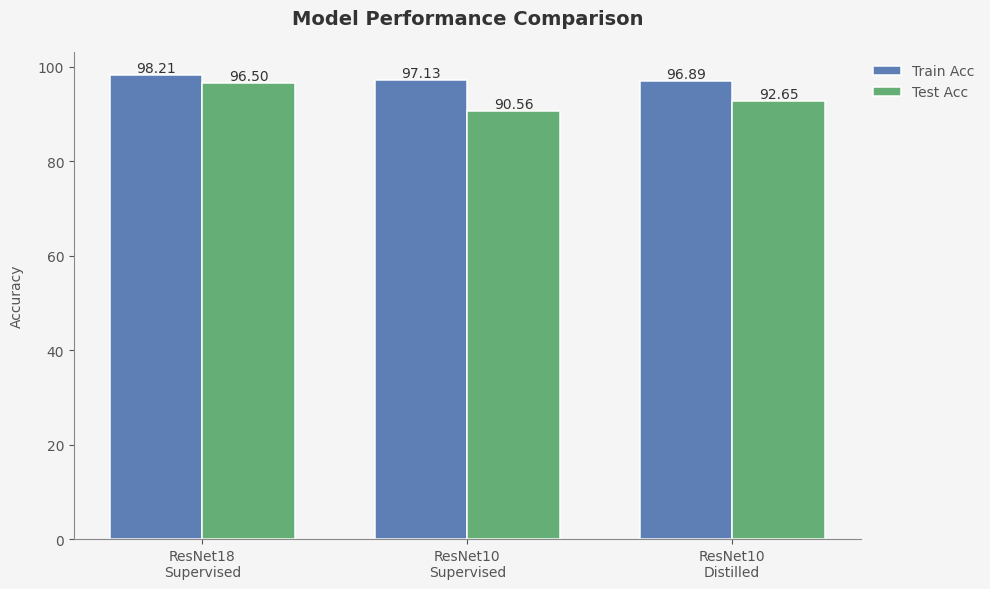

In [15]:
models = ['ResNet18\nSupervised', 'ResNet10\nSupervised', 'ResNet10\nDistilled']
train_acc = [train_acc_list_r18[-1], train_acc_list_r10[-1], train_acc_list_r10_kd[-1]]  # Your train losses
test_acc = [test_acc_list_r18[-1], test_acc_list_r10[-1], test_acc_list_r10_kd[-1]]    # Your test losses

# Modern, accessible color palette (Seaborn-inspired)
train_color = '#4c72b0'  # Soft blue
test_color = '#55a868'   # Soft green
bg_color = '#f5f5f5'     # Light gray background

# Create figure with light background
plt.figure(figsize=(10, 6), facecolor=bg_color)
ax = plt.gca()
ax.set_facecolor(bg_color)

# Bar settings
bar_width = 0.35
x = np.arange(len(models))
opacity = 0.9  # Slightly transparent for modern look

# Create bars with subtle edge
train_bars = ax.bar(x - bar_width/2, train_acc, bar_width,
                   color=train_color, alpha=opacity,
                   edgecolor='white', linewidth=1.2,
                   label='Train Acc')

test_bars = ax.bar(x + bar_width/2, test_acc, bar_width,
                  color=test_color, alpha=opacity,
                  edgecolor='white', linewidth=1.2,
                  label='Test Acc')

# Style improvements
ax.spines[['top', 'right']].set_visible(False)  # Remove top/right borders
ax.spines[['left', 'bottom']].set_color('#888888')  # Gray remaining borders
ax.tick_params(colors='#555555')  # Dark gray ticks

# Labels with modern styling
plt.title('Model Performance Comparison', pad=20,
          fontsize=14, weight='bold', color='#333333')
plt.ylabel('Accuracy', labelpad=10, color='#555555')
plt.xticks(x, models, color='#555555')

# Value labels with contrast
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height+0.02,
                f'{height:.2f}', ha='center', va='bottom',
                fontsize=10, color='#333333')

add_labels(train_bars)
add_labels(test_bars)

# Modern legend
plt.legend(frameon=False, bbox_to_anchor=(1, 1),
           labelcolor='#555555')

# Adjust layout
plt.tight_layout()
plt.show()

Based on the training experiments and the results shown in the figure above:

- The **ResNet18** model, trained using supervised learning for 10 epochs, achieved 98.21% training accuracy and 96.50% test accuracy.

- The **ResNet10** model, trained under the same settings (supervised learning for 10 epochs), reached 97.13% training accuracy but only 90.56% test accuracy. The significant gap between training and test accuracy suggests that the ResNet10 model overfitted the training data.

- When **ResNet10** was trained using **knowledge distillation** (with ResNet18 as the teacher model), it achieved 96.89% training accuracy and 92.65% test accuracy—an improvement of ~2% in test accuracy compared to its non-distilled counterpart. Additionally, the smaller gap between training and test accuracy indicates that the distilled ResNet10 generalizes better than the purely supervised version.

### Step-6: Export to ONNX

In [16]:
# Helper utility to export the model

def export_to_onnx(model, output_path):
    # Dummy input tensor for ONNX export
    dummy_input = torch.randn(1, 3, 224, 224)
    model.to("cpu")

    # Export the pruned model to ONNX
    torch.onnx.export(
        model, dummy_input, output_path,
        input_names=["input"], output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=11
    )

    print(f"Model has been exported to {output_path}")

In [17]:
# Export the distilled ResNet10 model

student_model_onnx_path = "./resnet10_cats_vs_dogs_distilled.onnx"
export_to_onnx(student_model, student_model_onnx_path)

Model has been exported to ./resnet10_cats_vs_dogs_distilled.onnx


In [18]:
# Visualize the exported model with dynamic shapes

import IPython
import netron

port = 6006
netron.start(student_model_onnx_path, port, browse=False)
IPython.display.IFrame(f"http://localhost:{port}", width=1000, height=500)